# Orientation check notebook

This notebook validates the scanner-space orientation convention used by the
2dseq orientation normalization.

Prereqs
- Test dataset available at `./data/TestSliceReadoutOrient.zip`
- `brkraw-sordino` installed in the environment
- `nibabel` installed for RAS reorientation checks



In [1]:
import sys
from typing import cast
from pprint import pprint
from pathlib import Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import brkraw as brk

ROOT = Path.cwd().resolve().parent
DEBUG_PATH = ROOT / "src"
sys.path.insert(0, str(DEBUG_PATH.resolve()))

from brkraw_sordino.hook import get_dataobj # type: ignore
from brkraw.specs.remapper import load_spec, map_parameters

In [2]:
def reorient_to_ras(data, affine):
    ornt = nib.orientations.io_orientation(affine)
    ras_ornt = np.array([[0, 1], [1, 1], [2, 1]])  # RAS
    transform = nib.orientations.ornt_transform(ornt, ras_ornt)
    new_data = nib.orientations.apply_orientation(data, transform)
    new_affine = affine @ nib.orientations.inv_ornt_aff(transform, data.shape)
    return new_data, new_affine

def _apply_affine(aff, ijk):
    ijk = np.asarray(ijk, dtype=float)
    ijk1 = np.c_[ijk, np.ones(len(ijk))]
    xyz = ijk1 @ aff.T
    return xyz[:, :3]

def _extent_for_plane(shape, affine, plane, fixed_index):
    nx, ny, nz = shape
    if plane == "axial":  # x-y at k
        corners = [(0, 0, fixed_index),
                   (nx - 1, 0, fixed_index),
                   (0, ny - 1, fixed_index),
                   (nx - 1, ny - 1, fixed_index)]
        world = _apply_affine(affine, corners)
        xs, ys = world[:, 0], world[:, 1]
        return [xs.min(), xs.max(), ys.min(), ys.max()]
    if plane == "coronal":  # x-z at j
        corners = [(0, fixed_index, 0),
                   (nx - 1, fixed_index, 0),
                   (0, fixed_index, nz - 1),
                   (nx - 1, fixed_index, nz - 1)]
        world = _apply_affine(affine, corners)
        xs, zs = world[:, 0], world[:, 2]
        return [xs.min(), xs.max(), zs.min(), zs.max()]
    if plane == "sagittal":  # y-z at i
        corners = [(fixed_index, 0, 0),
                   (fixed_index, ny - 1, 0),
                   (fixed_index, 0, nz - 1),
                   (fixed_index, ny - 1, nz - 1)]
        world = _apply_affine(affine, corners)
        ys, zs = world[:, 1], world[:, 2]
        return [ys.min(), ys.max(), zs.min(), zs.max()]
    raise ValueError("plane must be axial/coronal/sagittal")

def plot_orthogonal_world(dataobj, affine, title):
    nx, ny, nz = dataobj.shape
    i, j, k = nx // 2, ny // 2, nz // 2

    views = [
        ("Axial (x, y)", dataobj[:, :, k].T, _extent_for_plane(dataobj.shape, affine, "axial", k)),
        ("Coronal (x, z)", dataobj[:, j, :].T, _extent_for_plane(dataobj.shape, affine, "coronal", j)),
        ("Sagittal (y, z)", dataobj[i, :, :].T, _extent_for_plane(dataobj.shape, affine, "sagittal", i)),
    ]

    fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=70)
    for ax, (label, img, extent) in zip(axes, views):
        ax.imshow(img, cmap="gray", origin="lower", extent=extent)
        ax.set_title(label)
        ax.set_aspect("equal")
        ax.axis("off")

    fig.suptitle(title)
    plt.tight_layout()

# Orientation validation for non-Cartesian reconstruction

This notebook verifies that applying the 2dseq orientation convention yields
consistent scanner-space axes for non-Cartesian recon outputs.

## What was acquired
- Slice orientation sweep: axial/sagittal/coronal
- Readout orientation sweep: matched/mismatched pairs
- Each combination is reconstructed and checked for scanner-space axis consistency

## Method
- Reconstruct dataobj from raw FID with the SORDINO hook
- Apply orientation normalization (correct_orientation) when the first 3D axes are spatial
- Reorient volumes to RAS for comparison using nibabel
- Validate that scanner-space axes map as expected

## Expected scanner-space axes
- x/y map to operator LR and bottom-to-top
- z maps to front-to-back

## How to use
1. Run all cells top to bottom.
2. Inspect the printed orientation matrices and RAS-converted volumes.
3. Confirm the axis mapping holds for every slice/readout pair.

## Expected result
All combinations should satisfy the scanner-space axis conventions above after normalization.



In [4]:
scan_id = 5
scan = raw.get_scan(scan_id)
spec_path = Path().cwd().parent / "src" / "brkraw_sordino" / "specs" / "recon_spec.yaml"
spec, transforms = load_spec(spec_path, validate=True)
recon_info = map_parameters(scan, spec, transforms)
recon_info

{'SliceOrientation': 'coronal',
 'ReadoutOrientation': 'H_F',
 'GradientOrientation': array([[ 0,  0, -1],
        [-1,  0,  0],
        [ 0,  1,  0]]),
 'EncNReceivers': 1,
 'NPoints': 256,
 'NPro': 3200,
 'RepetitionTime_ms': 0.625,
 'EffBandwidth_Hz': 59523.8095238095,
 'OverSampling': 8.0,
 'AcqDelayTotal_us': 6.75,
 'NRepetitions': 5,
 'Matrix': array([64, 64, 64]),
 'UnderSampling': 263.214999999853,
 'HalfAcquisition': False,
 'UseOrigin': False,
 'Reorder': False}

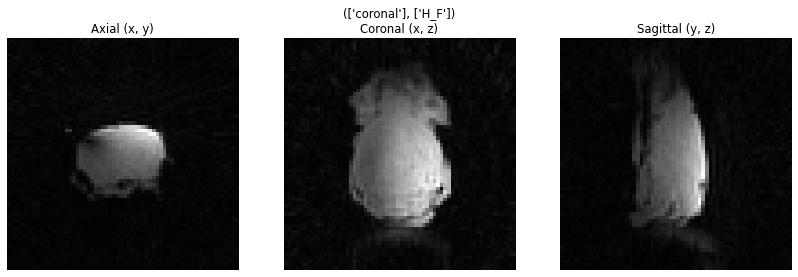

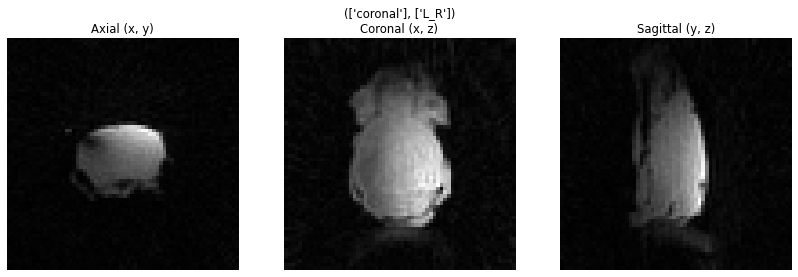

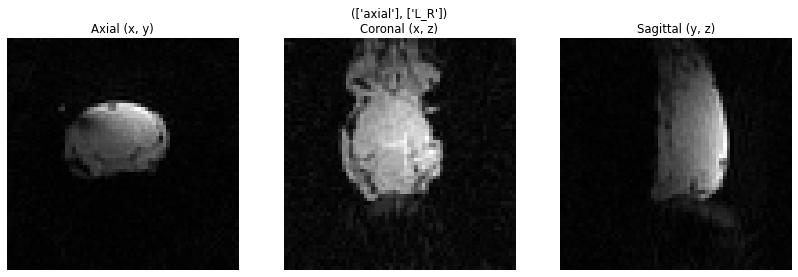

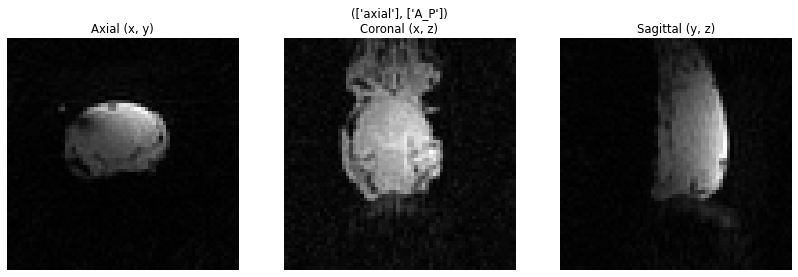

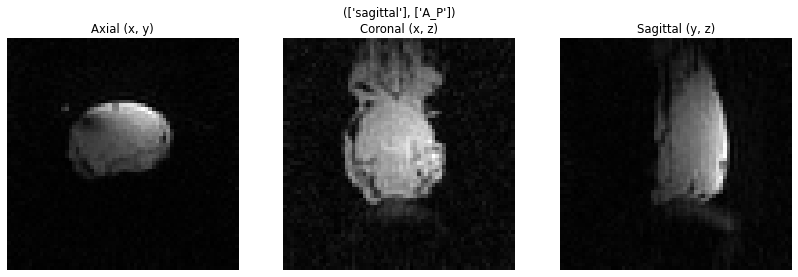

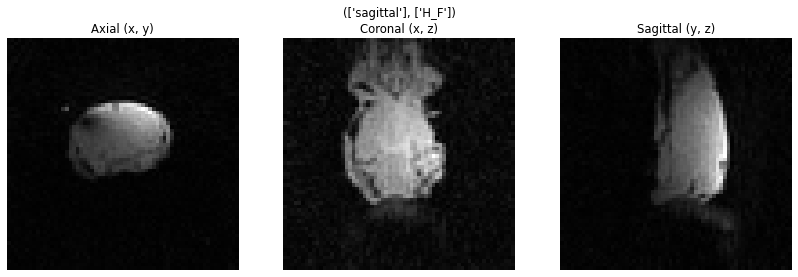

In [5]:
import numpy as np

grad_oris = {}

for scan_id, ori in orient_info.items():
    scan = raw.get_scan(scan_id)
    dataobj = get_dataobj(scan, cache_dir='./.tmp', correct_spoketiming=True)
    affine = raw.get_affine(scan_id=scan_id, reco_id=1, space='scanner')
    ras_img, ras_aff = reorient_to_ras(dataobj, affine)

    plot_orthogonal_world(ras_img.mean(-1), ras_aff, orient_info[scan_id])